## natural language experiments on a quantum computer.
### Goal-
submit a short report where you include the following:
- A short discussion explaining any design choices in the model, e.g. choice of loss
function, use of regularisation or not and so on.  
- A short discussion on the results.  
- Optimisation plots showing the convergence of the model.  
### Possible Extensions-
- Diagrammatic rewriting
- Different ansatze
- Implement a new reader
- Implement a rewrite rule

touching field: (direction)
- quantum mechanics
- pure math and particular category theory
- linguistics 
- artifical intelligence

qnlp tutorial: https://youtu.be/GQBUBH_g3fU?t=5424
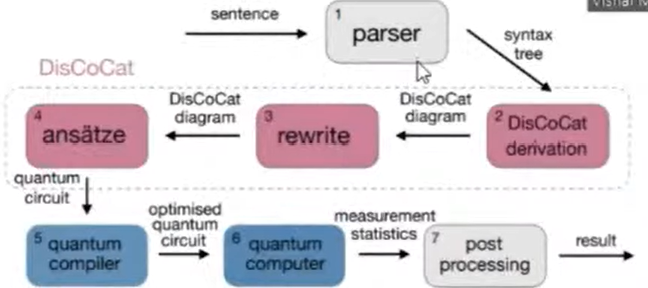
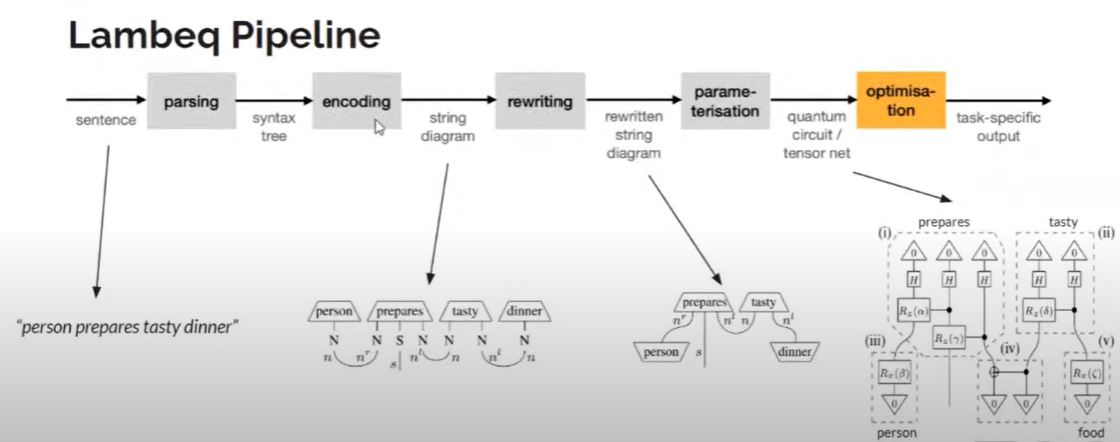

reference:
- https://arxiv.org/pdf/2102.12846.pdf
- https://arxiv.org/pdf/1905.10876.pdf
- https://arxiv.org/pdf/2110.04236.pdf

## compare different

In [8]:
from lambeq import Reader, cups_reader, spiders_reader, stairs_reader,BobcatParser

##### try different ansatz

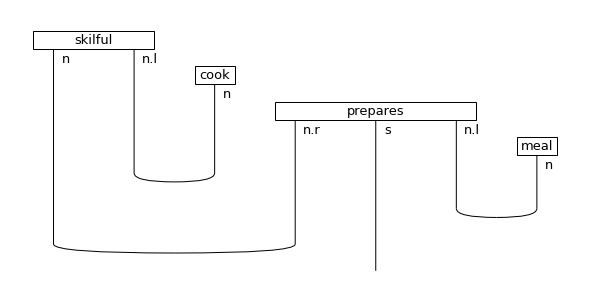

In [5]:
parser = BobcatParser(root_cats=('NP', 'N', 'S'), verbose='text')
train_diagrams = parser.sentence2diagram('skilful cook prepares meal .', suppress_exceptions=True)
train_diagrams.draw(figsize=(8,4), fontsize=13)

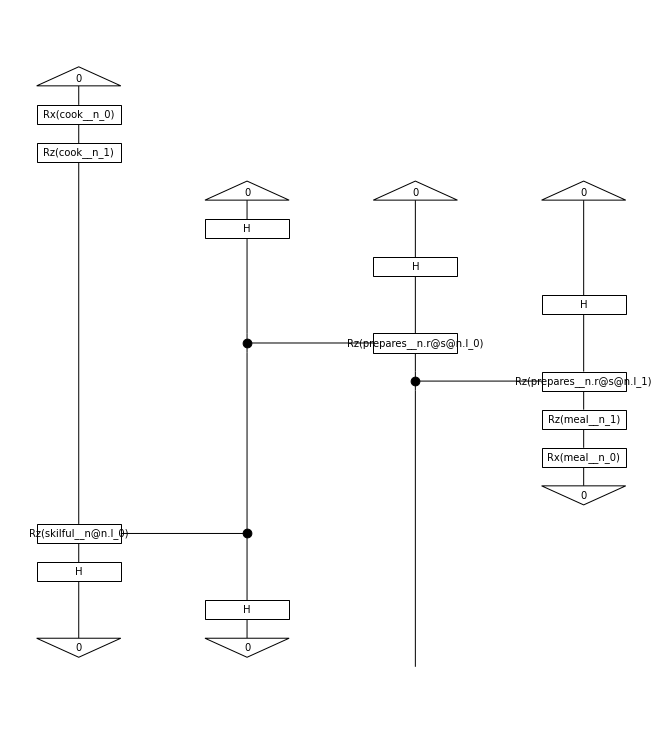

In [6]:
from lambeq import AtomicType, IQPAnsatz, remove_cups, SpiderAnsatz
from discopy import Dim

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=2)
ansatz_circuit= ansatz(remove_cups(train_diagrams))
ansatz_circuit.draw(figsize=(9, 10))

In [7]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = ansatz_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

##### custom ansatze

example:

In [8]:
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.gates import Bra, CX, Ket, Ry, Rotation
from lambeq import CircuitAnsatz
from lambeq.ansatz import Symbol

class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers):
        super().__init__(ob_map=ob_map, n_layers=n_layers)

        self.n_layers = n_layers
        self.functor = Functor(ob=self.ob_map, ar=self._ar)


    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        
        # step 3: construct and return ansatz
        if n_qubits == 1:
            circuit = Ry(Symbol(f'{label}_0'))
            print(label)
        else:
            # this also deals with the n_qubits == 0 case correctly
            circuit = Id(n_qubits)
            for i in range(n_layers):
                offset = i * n_qubits
                syms = [Symbol(f'{label}_{offset + j}') for j in range(n_qubits)]

                # adds a ladder of CNOTs
                for j in range(n_qubits - 1):
                    circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

                # adds a layer of Y rotations
                circuit >>= Id().tensor(*[Ry(sym) for sym in syms])

        if cod <= dom:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        else:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        return circuit

cook__n
meal__n


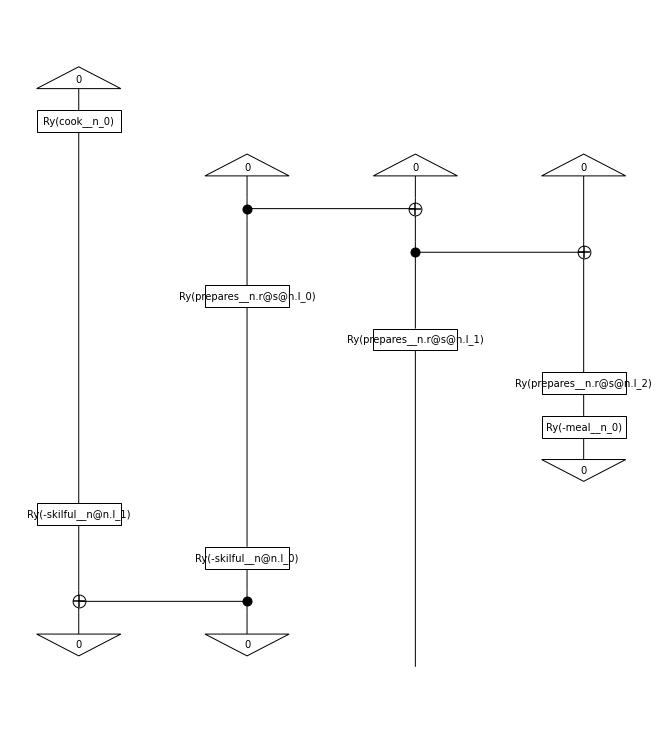

In [9]:
custom_ansatz = RealAnsatz(ob_map={AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)
ansatz_circuit= custom_ansatz(remove_cups(train_diagrams))
ansatz_circuit.draw(figsize=(9, 10))

In [29]:
tket_circuit = ansatz_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

but we want to try other entanglement type, other than linear entanglement:  
(TwoLocal(rotation_blocks='R',entanglement_blocks='cx',entanglement='circular',reps=2)) 
reference: https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html  
from https://odr.chalmers.se/bitstream/20.500.12380/302687/1/Master_thesis_Thomas_Hoffmann.pdf
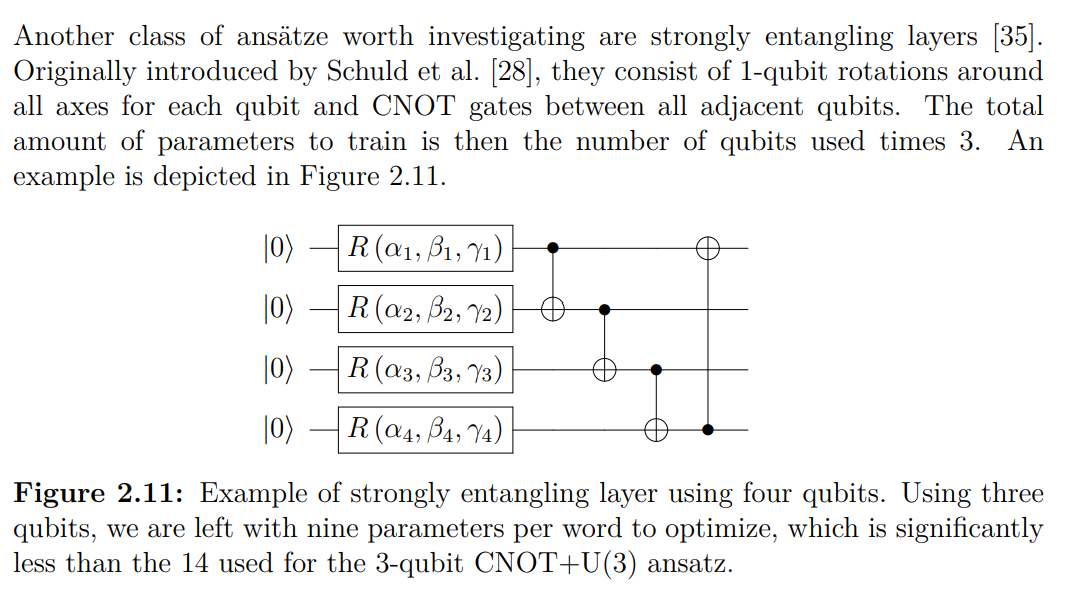

In [32]:
class StrongeAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers):
        super().__init__(ob_map=ob_map, n_layers=n_layers)

        self.n_layers = n_layers
        self.functor = Functor(ob=self.ob_map, ar=self._ar)


    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        
        # step 3: construct and return ansatz
        #working

        if cod <= dom:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        else:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        return circuit

In [ ]:
custom_ansatz = RealAnsatz(ob_map={AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)
ansatz_circuit= custom_ansatz(remove_cups(train_diagrams))
ansatz_circuit.draw(figsize=(9, 10))

In [ ]:
tket_circuit = ansatz_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

##### compare different no cup

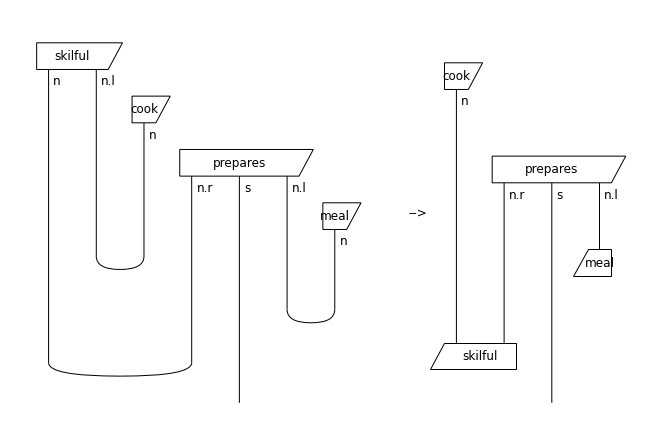

In [28]:
from discopy.drawing import equation

original_diagram = train_diagrams
removed_cups_diagram = remove_cups(original_diagram)

equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

## implement

### import important tool
using jax for high performance

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

import os
os.environ["TOKENIZERS_PARALLELISM"] = "False"

from discopy.tensor import Tensor
#from jax import numpy as np
import numpy as np

#np.random = numpy.random
#Tensor.np = np

np.random.seed(123458)  # Fix the seed
np.set_printoptions(precision=10) #print out float point

### Read in the data and create diagrams

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename, 'r') as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')
val_labels, val_data = test_labels, test_data 

In [3]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

In [4]:
train_labels[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [0, 1]]

### Create diagrams
#### Generate full diagrams for train

In [5]:
from lambeq import BobcatParser
#root_cats so it parsed correctly, verbose='text' so it give text report
parser = BobcatParser(root_cats=('NP', 'N', 'S'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_dev_diagrams = parser.sentences2diagrams(dev_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


check diagram is not empty in normal_form()

In [6]:
#train_diagrams = [
#    diagram.normal_form()
#    for diagram in raw_train_diagrams if diagram is not None
#]
#dev_diagrams = [
#    diagram.normal_form()
#    for diagram in raw_dev_diagrams if diagram is not None
#]
#val_diagrams = [
#    diagram.normal_form()
#    for diagram in raw_val_diagrams if diagram is not None
#]
#
#train_labels = [
#    label for (diagram, label)
#    in zip(raw_train_diagrams, train_labels)
#    if diagram is not None]
#dev_labels = [
#    label for (diagram, label)
#    in zip(raw_dev_diagrams, dev_labels)
#    if diagram is not None]
#val_labels = [
#    label for (diagram, label)
#    in zip(raw_val_diagrams, val_labels)
#    if diagram is not None
#]

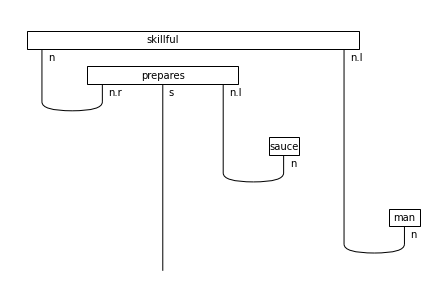

In [ ]:
#train_diagrams[0].draw()

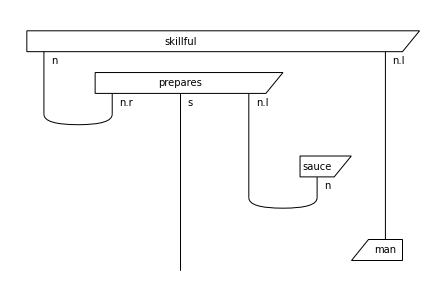

In [ ]:
#remove_cups(train_diagrams[0]).draw()

### Remove the Cups && Create Ansatz circuit

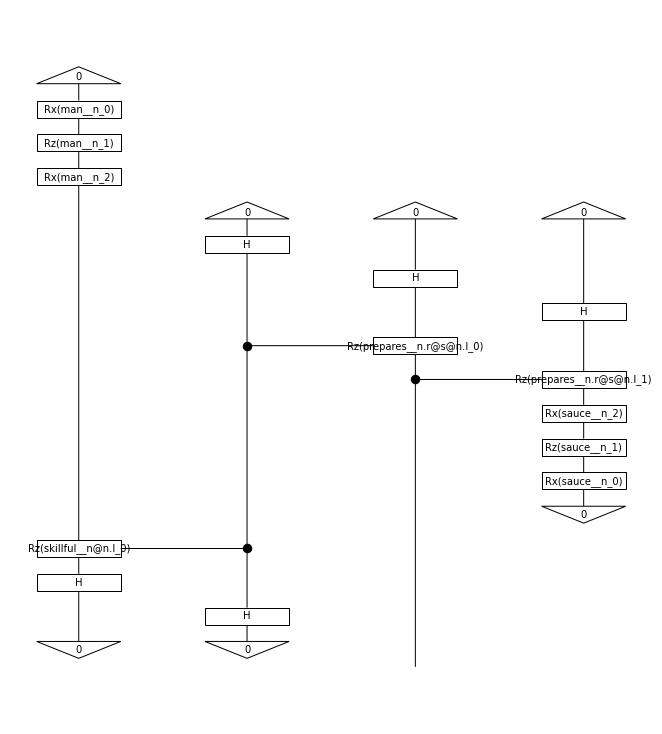

In [7]:
from lambeq import AtomicType, IQPAnsatz, remove_cups
from discopy import Dim

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_diagrams= raw_train_diagrams
dev_diagrams= raw_dev_diagrams
val_diagrams= raw_val_diagrams


train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
dev_circuits = [ansatz(remove_cups(diagram)) for diagram in dev_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

In [8]:
def read_testing_data(filename):
    labels, sentences = [], []
    with open(filename, 'r') as f:
        for line in f:
            fields = line.split(',')
            t = int(fields[-1])
            labels.append([t,1-t])
            sentences.append(fields[:-1])
    return labels, sentences
testing_labels, testing_data = read_testing_data('MC1.TXT')

In [9]:
testing_data_ = []
for test in testing_data: 
    testing_data_.append(str(",".join(w for word in test for w in word.split(","))))

In [10]:
raw_testing_diagrams = parser.sentences2diagrams(testing_data_, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [11]:
testing_circuits = [ansatz(remove_cups(diagram)) for diagram in raw_testing_diagrams]

jax

In [12]:
#ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2), AtomicType.SENTENCE: Dim(2)})
#
#train_circuits = [ansatz(d) for d in train_diagrams]
#test_circuits = [ansatz(d) for d in test_diagrams]
#
#all_circuits = train_circuits + test_circuits
#
#all_circuits[0].draw(figsize=(8,4), fontsize=13)
## Create vocabulary
#
#from sympy import default_sort_key
#
#vocab = sorted(
#   {sym for circ in all_circuits for sym in circ.free_symbols},
#    key=default_sort_key
#)
#tensors = [np.random.rand(w.size) for w in vocab]
#
#tensors[0]

### Choose backend

#### 1. Aerbackend

In [13]:
#from pytket.extensions.qiskit import AerBackend
#from lambeq import TketModel
#
#all_circuits = train_circuits + dev_circuits + val_circuits
#
#backend = AerBackend()
#backend_config = {
#    'backend': backend,
#    'compilation': backend.default_compilation_pass(2),
#    'shots': 8192
#}
#
#model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

#### 2. NumpyModel

In [14]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + val_circuits + testing_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

### Define evaluation metric

In [15]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

jax

In [16]:
#from jax import jit, grad
#
#def sigmoid(x):
#    return 1 / (1 + np.exp(-x))
#
#def loss(tensors):
#    # Lambdify
#    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
#    # Compute predictions
#    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))
#
#    # binary cross-entropy loss
#    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
#    return cost
#
#loss = jit(loss)
#acc = jit(grad(loss))

### Initialize trainer

In [17]:
BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

In [18]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS}, #{'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS}
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [19]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=True)

### Train

In [20]:
#logging_step so it give report every 12 steps
trainer.fit(train_dataset, val_dataset, logging_step=12) 

Epoch 1:    train/loss: 0.8196   valid/loss: 0.6182   train/acc: 0.4000   valid/acc: 0.5667
Epoch 12:   train/loss: 0.6687   valid/loss: 0.5646   train/acc: 0.5857   valid/acc: 0.6333
Epoch 24:   train/loss: 0.5181   valid/loss: 0.4940   train/acc: 0.8286   valid/acc: 0.7333
Epoch 36:   train/loss: 0.4431   valid/loss: 0.5199   train/acc: 0.9571   valid/acc: 0.8667
Epoch 48:   train/loss: 0.3661   valid/loss: 0.4620   train/acc: 0.9857   valid/acc: 0.9000
Epoch 60:   train/loss: 0.3476   valid/loss: 0.3489   train/acc: 0.9857   valid/acc: 0.9667
Epoch 72:   train/loss: 0.2873   valid/loss: 0.3402   train/acc: 0.9857   valid/acc: 0.9333
Epoch 84:   train/loss: 0.2687   valid/loss: 0.3257   train/acc: 1.0000   valid/acc: 0.9667
Epoch 96:   train/loss: 0.2745   valid/loss: 0.3325   train/acc: 0.9571   valid/acc: 0.9000
Epoch 108:  train/loss: 0.2423   valid/loss: 0.2822   train/acc: 0.9857   valid/acc: 1.0000
Epoch 120:  train/loss: 0.2477   valid/loss: 0.2775   train/acc: 0.9286   valid/

### plot graph

Validation accuracy: 0.9666666666666667


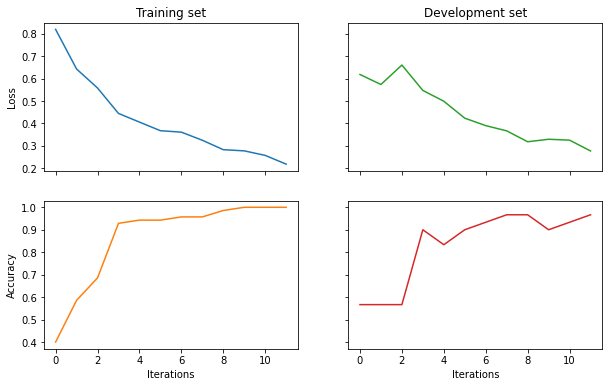

In [21]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

#### test result:
- food: “skilful cook prepares meal”
- IT: “programmer writes complicated code

In [25]:
accuracy = model(testing_circuits)
print(acc(accuracy,testing_labels))
print(testing_data_[0])
accuracy[0],testing_labels[0]

0.61
cook creates complicated dish, experienced chef prepares complicated dish


(array([0.6453536 , 0.35464633], dtype=float32), [1, 0])

In [133]:
print('sentence:',testing_data_[61])
print('category food or IT:',testing_labels[61])
print('accuracy:\n',accuracy[61][0]*100,'% is IT\n', accuracy[61][1]*100,'% is food')

sentence: programmer writes complicated code, skilful cook creates tasty dish
category food or IT: [0, 1]
accuracy:
 56.7099928855896 % is IT
 43.289998173713684 % is food


In [64]:
try_testing_data_ = testing_data_[61].split(",")
try_testing_data_

['programmer writes complicated code', ' skilful cook creates tasty dish']

In [121]:
def determine_food_IT(sentence:list):
    try_raw_testing_diagrams = parser.sentences2diagrams(sentence, suppress_exceptions=True)
    try_testing_circuits = [ansatz(remove_cups(diagram)) for diagram in try_raw_testing_diagrams]
    try_accuracy = model(try_testing_circuits)
    for i in range(len(try_accuracy)):
        print('accuracy for ({}):\n'.format(sentence[i]),try_accuracy[i][0]*100,'% is IT\n', try_accuracy[i][1]*100,'% is food')

In [132]:
determine_food_IT(try_testing_data_)

Tagging sentences.


accuracy for (programmer writes complicated code):
 86.91491484642029 % is IT
 13.08508962392807 % is food
accuracy for ( skilful cook creates tasty dish):
 59.43726897239685 % is IT
 40.56272804737091 % is food


Parsing tagged sentences.
Turning parse trees to diagrams.


In [131]:
determine_food_IT(['programmer'])

Tagging sentences.


accuracy for (programmer):
 60.89051961898804 % is IT
 39.10948038101196 % is food


Parsing tagged sentences.
Turning parse trees to diagrams.
